In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from src.utils_clustering_v2 import load_labels_from_file, map_clusters_to_ground_truth, evaluate_clustering, generate_confusion_matrix

# Ignore all warnings
warnings.filterwarnings("ignore")

In [21]:
DATASET_FILE_NAME = "b1"
file_path = rf'..\data\processed\{DATASET_FILE_NAME}.txt'
processed_data = pd.read_csv(file_path)

In [22]:
LABELS_FILE_NAME = f'{DATASET_FILE_NAME}-gt.pa'
labels_true = load_labels_from_file(rf'..\data\label\{LABELS_FILE_NAME}', 15)

clustering_algorithm_name = 'KMeans_clustering'
dataset_name = DATASET_FILE_NAME

# Evaluating Clustering Algorithm with Train, Validation, and Test Sets

When evaluating clustering algorithms, splitting data into training, validation, and test sets helps in tuning hyperparameters and assessing the algorithm's generalizability. Here's how each dataset is used:

## Training Set
- **Usage**: The training set is used to fit the clustering model. It helps the model learn the data's structure and distribution.
- **Purpose**: Optimize the algorithm's internal parameters.

## Validation Set
- **Usage**: The validation set is used to tune hyperparameters. After training the model, this set helps in evaluating different hyperparameter configurations.
- **Purpose**: Select the best hyperparameters without overfitting to the test data. It acts as a proxy for the test set to prevent leakage of test data information.

## Test Set
- **Usage**: The test set is used to evaluate the final model's performance after training and validation phases are complete. It provides an unbiased assessment of the model's effectiveness on unseen data.
- **Purpose**: Assess the generalizability of the clustering algorithm to new data. It measures how well the chosen model and hyperparameters perform on data not seen during the training or validation process.

## Retraining with Selected Hyperparameters
After tuning the hyperparameters using the training and validation sets, the algorithm is retrained with the selected hyperparameters using the combined data from both the training set and validation set. This approach leverages a larger dataset for training, potentially leading to a more robust and well-generalized model.

## Final Model Evaluation
The retrained model is then evaluated on the test set to assess its performance. This final step provides an unbiased evaluation of the model's ability to generalize to new, unseen data, reflecting its real-world applicability and effectiveness.

By segregating the dataset into these three parts and retraining with selected hyperparameters, we can iteratively refine our model and ensure that our final evaluation metrics are a reliable indicator of the model's real-world performance.


In [23]:
# Split the data into train and temp (temp will contain both validate and test)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    processed_data, labels_true, train_size=0.5, random_state=42)

# Split the temp data into validate and test
validate_data, test_data, validate_labels, test_labels = train_test_split(
    temp_data, temp_labels, train_size=0.5, random_state=42)

# You now have train_data, validate_data, and test_data
print(f"Train set size: {len(train_data)}")
print(f"Validate set size: {len(validate_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 50000
Validate set size: 25000
Test set size: 25000


In [24]:
# Define hyperparameter space directly here for clarity
N_CLUSTERS = 100
hyperparameter_domains = {
    'n_clusters': [N_CLUSTERS],
    'init': ['k-means++', 'random'],
    'n_init': np.arange(5, 100, 20),
    'max_iter': [100, 300, 1000],
    'algorithm': ['auto', 'elkan', 'full']
}

n_iter = 10

VERSION = '0.1.1'

In [25]:
from sklearn.cluster import KMeans
import time
from sklearn.model_selection import ParameterSampler


def calculate_grid_size(space):
    # For each parameter, count the number of unique values and multiply them
    return np.prod([len(values) for values in space.values()])


grid_size = calculate_grid_size(hyperparameter_domains)
print(f"{clustering_algorithm_name} hyperparameter grid size: {grid_size}")

KMeans_clustering hyperparameter grid size: 90


## Tuning Hyperparameters:

In [26]:
results_path = rf'../results/metrics/results_kmeans_{DATASET_FILE_NAME}_v{VERSION}.csv'



parameter_sampler = ParameterSampler(hyperparameter_domains, n_iter=n_iter, random_state=42)

# Debugging: Print the number of configurations to run
print(f"Total configurations to run: {n_iter}")

# Run clustering for each configuration
for i, params in enumerate(parameter_sampler, start=1):
    print(f"Running configuration {i}/{n_iter}: {params}")  # Debugging: print before running
    start_time = time.time()

    # Initialize and fit KMeans
    kmeans_clustering = KMeans(**params, random_state=42)

    # Start timing the training phase
    training_start_time = time.time()

    # Fit KMeans using only the training data
    kmeans_clustering.fit(train_data)

    # End timing the training phase
    training_end_time = time.time()
    training_time = (training_end_time - training_start_time)

    # Start timing the prediction phase
    prediction_start_time = time.time()

    # Predict labels for the validation or test data
    labels_pred = kmeans_clustering.predict(validate_data)

    # End timing the prediction phase
    prediction_end_time = time.time()
    prediction_time = (prediction_end_time - prediction_start_time)

    algorithm_params = kmeans_clustering.get_params()
    algorithm_details = str(algorithm_params)

    labels_pred = map_clusters_to_ground_truth(validate_labels, labels_pred)
    evaluate_clustering(X=validate_data, labels_true=validate_labels, labels_pred=labels_pred,
                        clus_algo_name=clustering_algorithm_name, dataset_name=dataset_name,
                        results_path=results_path, algorithm_details=algorithm_details,
                        training_time=training_time, prediction_time=prediction_time)
    # generate_confusion_matrix(labels_true, labels_pred, N_CLUSTERS)

Total configurations to run: 10
Running configuration 1/10: {'n_init': 5, 'n_clusters': 100, 'max_iter': 1000, 'init': 'k-means++', 'algorithm': 'elkan'}
Running configuration 2/10: {'n_init': 45, 'n_clusters': 100, 'max_iter': 300, 'init': 'random', 'algorithm': 'auto'}
Running configuration 3/10: {'n_init': 5, 'n_clusters': 100, 'max_iter': 1000, 'init': 'random', 'algorithm': 'elkan'}
Running configuration 4/10: {'n_init': 5, 'n_clusters': 100, 'max_iter': 1000, 'init': 'k-means++', 'algorithm': 'full'}
Running configuration 5/10: {'n_init': 5, 'n_clusters': 100, 'max_iter': 100, 'init': 'k-means++', 'algorithm': 'auto'}
Running configuration 6/10: {'n_init': 25, 'n_clusters': 100, 'max_iter': 1000, 'init': 'random', 'algorithm': 'auto'}
Running configuration 7/10: {'n_init': 85, 'n_clusters': 100, 'max_iter': 300, 'init': 'k-means++', 'algorithm': 'elkan'}
Running configuration 8/10: {'n_init': 5, 'n_clusters': 100, 'max_iter': 300, 'init': 'k-means++', 'algorithm': 'full'}
Running

In [27]:
FILE_NAME = f'results_kmeans_{DATASET_FILE_NAME}_v{VERSION}.csv'
file_path = rf'..\results\metrics\{FILE_NAME}'
csv_content = pd.read_csv(file_path)

# Find the record with the highest accuracy
max_accuracy_record = csv_content.loc[csv_content['Accuracy'].idxmax()]

# Display the record with the highest accuracy
print(max_accuracy_record)
print(max_accuracy_record['Algorithm Details'])

Timestamp                                               2024-02-17 06:15:08.440421
Dataset                                                                         b1
Clustering Algorithm                                             KMeans_clustering
Algorithm Details                {'algorithm': 'full', 'copy_x': True, 'init': ...
Training Time                                                            24.656218
Prediction Time                                                           0.002909
AMI                                                                       0.990988
ARI                                                                       0.986029
Calinski-Harabasz Score                                               37758.678645
Davies-Bouldin Score                                                      0.615089
Completeness Score                                                         0.99142
Fowlkes-Mallows Score                                                     0.986169
Homo

## Final Model Evaluation

Confusion Matrix:


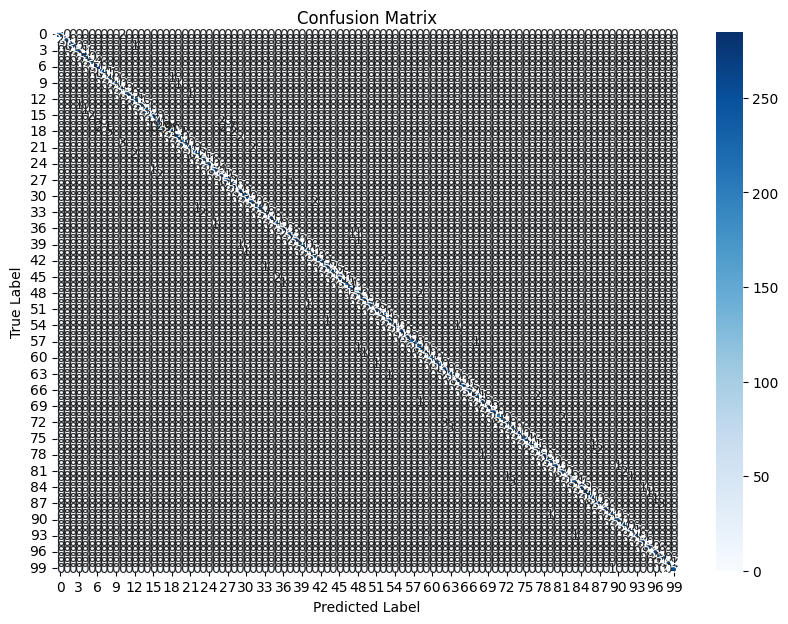


Overall Accuracy: 97.54%
This represents the proportion of all data points that were correctly grouped by the clustering algorithm.


In [28]:
results_path = rf'../results/metrics/results_kmeans_final_{DATASET_FILE_NAME}_v0.0.8.csv'

combined_train_data = pd.concat([train_data, validate_data])
combined_train_labels = np.concatenate([train_labels, validate_labels])

# Initialize KMeans with the best hyperparameters
best_params = max_accuracy_record['Algorithm Details']  # Assume this contains the best parameters
kmeans_final = KMeans(**eval(best_params))

# Start timing the training phase
training_start_time = time.time()

# Retrain using the combined dataset
kmeans_final.fit(combined_train_data)

# End timing the training phase
training_end_time = time.time()
training_time = (training_end_time - training_start_time)

# Start timing the prediction phase
prediction_start_time = time.time()

# Predict on the test set
final_labels_pred = kmeans_final.predict(test_data)

# End timing the prediction phase
prediction_end_time = time.time()
prediction_time = (prediction_end_time - prediction_start_time)

algorithm_params = kmeans_final.get_params()
algorithm_details = str(algorithm_params)

# Map predicted labels to ground truth labels for the test set
final_labels_pred= map_clusters_to_ground_truth(test_labels, final_labels_pred)
generate_confusion_matrix(test_labels, final_labels_pred, N_CLUSTERS)

evaluate_clustering(X=test_data, labels_true=test_labels, labels_pred=final_labels_pred,
                    clus_algo_name=clustering_algorithm_name, dataset_name=dataset_name,
                    results_path=results_path, algorithm_details=algorithm_details,
                    training_time=training_time, prediction_time=prediction_time)

In [29]:
# DATASET_FILE_NAME = "b2"
# LABELS_FILE_NAME = f'{DATASET_FILE_NAME}-gt.pa'
# labels_true = load_labels_from_file(rf'..\data\label\{LABELS_FILE_NAME}', 15)
# distinct_count = len(set(labels_true))
# distinct_count

Train set size: 50000
Validate set size: 25000
Test set size: 25000
KMeans_clustering hyperparameter grid size: 90
Total configurations to run: 10
Running configuration 1/10: {'n_init': 5, 'n_clusters': 100, 'max_iter': 1000, 'init': 'k-means++', 'algorithm': 'elkan'}
Running configuration 2/10: {'n_init': 45, 'n_clusters': 100, 'max_iter': 300, 'init': 'random', 'algorithm': 'auto'}
Running configuration 3/10: {'n_init': 5, 'n_clusters': 100, 'max_iter': 1000, 'init': 'random', 'algorithm': 'elkan'}
Running configuration 4/10: {'n_init': 5, 'n_clusters': 100, 'max_iter': 1000, 'init': 'k-means++', 'algorithm': 'full'}
Running configuration 5/10: {'n_init': 5, 'n_clusters': 100, 'max_iter': 100, 'init': 'k-means++', 'algorithm': 'auto'}
Running configuration 6/10: {'n_init': 25, 'n_clusters': 100, 'max_iter': 1000, 'init': 'random', 'algorithm': 'auto'}
Running configuration 7/10: {'n_init': 85, 'n_clusters': 100, 'max_iter': 300, 'init': 'k-means++', 'algorithm': 'elkan'}
Running conf

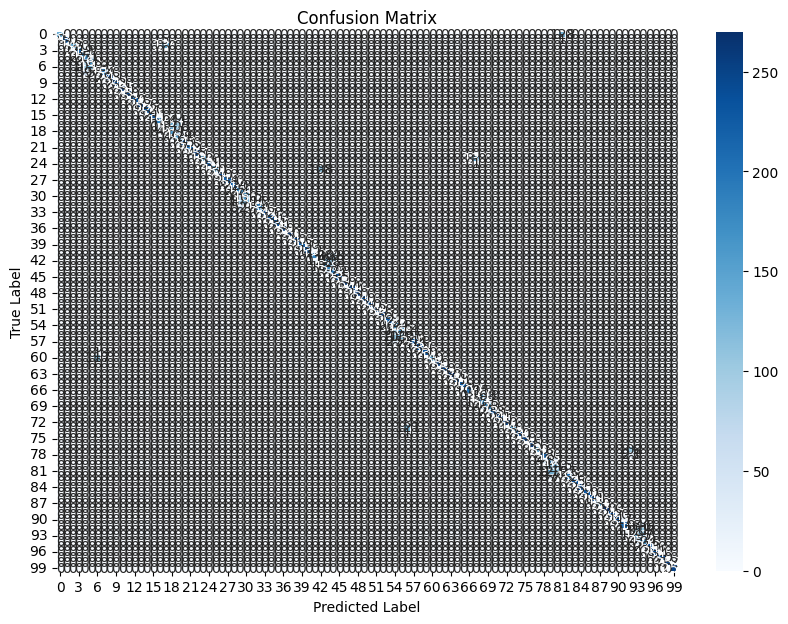


Overall Accuracy: 79.68%
This represents the proportion of all data points that were correctly grouped by the clustering algorithm.


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from src.utils_clustering_v2 import load_labels_from_file, map_clusters_to_ground_truth, evaluate_clustering, \
    generate_confusion_matrix

# Ignore all warnings
warnings.filterwarnings("ignore")
DATASET_FILE_NAME = "b2"
file_path = rf'..\data\processed\{DATASET_FILE_NAME}.txt'
processed_data = pd.read_csv(file_path)
LABELS_FILE_NAME = f'{DATASET_FILE_NAME}-gt.pa'
labels_true = load_labels_from_file(rf'..\data\label\{LABELS_FILE_NAME}', 15)

clustering_algorithm_name = 'KMeans_clustering'
dataset_name = DATASET_FILE_NAME
# Evaluating Clustering Algorithm with Train, Validation, and Test Sets

# Split the data into train and temp (temp will contain both validate and test)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    processed_data, labels_true, train_size=0.5, random_state=42)

# Split the temp data into validate and test
validate_data, test_data, validate_labels, test_labels = train_test_split(
    temp_data, temp_labels, train_size=0.5, random_state=42)

# You now have train_data, validate_data, and test_data
print(f"Train set size: {len(train_data)}")
print(f"Validate set size: {len(validate_data)}")
print(f"Test set size: {len(test_data)}")

# Define hyperparameter space directly here for clarity
N_CLUSTERS = 100
hyperparameter_domains = {
    'n_clusters': [N_CLUSTERS],
    'init': ['k-means++', 'random'],
    'n_init': np.arange(5, 100, 20),
    'max_iter': [100, 300, 1000],
    'algorithm': ['auto', 'elkan', 'full']
}

from sklearn.cluster import KMeans
import time
from sklearn.model_selection import ParameterSampler


def calculate_grid_size(space):
    # For each parameter, count the number of unique values and multiply them
    return np.prod([len(values) for values in space.values()])


grid_size = calculate_grid_size(hyperparameter_domains)
print(f"{clustering_algorithm_name} hyperparameter grid size: {grid_size}")
results_path = rf'../results/metrics/results_kmeans_{DATASET_FILE_NAME}_v{VERSION}.csv'

# Sample configurations

parameter_sampler = ParameterSampler(hyperparameter_domains, n_iter=n_iter, random_state=42)

# Debugging: Print the number of configurations to run
print(f"Total configurations to run: {n_iter}")

# Run clustering for each configuration
for i, params in enumerate(parameter_sampler, start=1):
    print(f"Running configuration {i}/{n_iter}: {params}")  # Debugging: print before running
    start_time = time.time()

    # Initialize and fit KMeans
    kmeans_clustering = KMeans(**params, random_state=42)

    # Start timing the training phase
    training_start_time = time.time()

    # Fit KMeans using only the training data
    kmeans_clustering.fit(train_data)

    # End timing the training phase
    training_end_time = time.time()
    training_time = (training_end_time - training_start_time)

    # Start timing the prediction phase
    prediction_start_time = time.time()

    # Predict labels for the validation or test data
    labels_pred = kmeans_clustering.predict(validate_data)

    # End timing the prediction phase
    prediction_end_time = time.time()
    prediction_time = (prediction_end_time - prediction_start_time)

    algorithm_params = kmeans_clustering.get_params()
    algorithm_details = str(algorithm_params)

    labels_pred = map_clusters_to_ground_truth(validate_labels, labels_pred)
    evaluate_clustering(X=validate_data, labels_true=validate_labels, labels_pred=labels_pred,
                        clus_algo_name=clustering_algorithm_name, dataset_name=dataset_name,
                        results_path=results_path, algorithm_details=algorithm_details,
                        training_time=training_time, prediction_time=prediction_time)
    # generate_confusion_matrix(labels_true, labels_pred, N_CLUSTERS)
FILE_NAME = f'results_kmeans_{DATASET_FILE_NAME}_v{VERSION}.csv'
file_path = rf'..\results\metrics\{FILE_NAME}'
csv_content = pd.read_csv(file_path)

# Find the record with the highest accuracy
max_accuracy_record = csv_content.loc[csv_content['Accuracy'].idxmax()]

# Display the record with the highest accuracy
print(max_accuracy_record)
print(max_accuracy_record['Algorithm Details'])
results_path = rf'../results/metrics/results_kmeans_final_{DATASET_FILE_NAME}_v{VERSION}.csv'

combined_train_data = pd.concat([train_data, validate_data])
combined_train_labels = np.concatenate([train_labels, validate_labels])

# Initialize KMeans with the best hyperparameters
best_params = max_accuracy_record['Algorithm Details']  # Assume this contains the best parameters
kmeans_final = KMeans(**eval(best_params))

# Start timing the training phase
training_start_time = time.time()

# Retrain using the combined dataset
kmeans_final.fit(combined_train_data)

# End timing the training phase
training_end_time = time.time()
training_time = (training_end_time - training_start_time)

# Start timing the prediction phase
prediction_start_time = time.time()

# Predict on the test set
final_labels_pred = kmeans_final.predict(test_data)

# End timing the prediction phase
prediction_end_time = time.time()
prediction_time = (prediction_end_time - prediction_start_time)

algorithm_params = kmeans_final.get_params()
algorithm_details = str(algorithm_params)

# Map predicted labels to ground truth labels for the test set
final_labels_pred = map_clusters_to_ground_truth(test_labels, final_labels_pred)
generate_confusion_matrix(test_labels, final_labels_pred, N_CLUSTERS)

evaluate_clustering(X=test_data, labels_true=test_labels, labels_pred=final_labels_pred,
                    clus_algo_name=clustering_algorithm_name, dataset_name=dataset_name,
                    results_path=results_path, algorithm_details=algorithm_details,
                    training_time=training_time, prediction_time=prediction_time)